In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/schmidt'

In [3]:
#Sometimes important data is shared along with code.
#https://zenodo.org/records/5784651

In [4]:
meta = pd.read_csv(cwd+'/data/GSE190604_cellranger-guidecalls-aggregated-unfiltered.txt.gz', compression='gzip', delimiter='\t', header=0)

meta.rename(columns={'cell_barcode':'CellID', 'num_features':'nFeature', 'feature_call':'FeatureCall', 'num_umis':'nUMI'}, inplace=True)

meta = meta[meta['nFeature']==1]
meta['nUMI'] = meta['nUMI'].astype(int)
meta = meta[meta['nUMI']>=5]

meta['SampleID'] = meta['CellID'].str.split('-').str[1]
meta['StimulationStatus'] = np.where(meta['CellID'].str.contains('-1|-2|-3|-4'), 'NotStimulated', 'Stimulated')
meta['PerturbedGene'] = meta['FeatureCall'].replace(r'-[0-9]', '', regex=True)
meta['PerturbationStatus'] = np.where(meta['PerturbedGene']=='NO-TARGET', 'NotPerturbed', 'Perturbed')

meta.drop(columns=['nFeature', 'FeatureCall'], inplace=True)

meta

,CellID,nUMI,SampleID,StimulationStatus,PerturbedGene,PerturbationStatus
0,GGGAGATAGACCGTTT-1,216,1,NotStimulated,ABCB10,Perturbed
1,GACGCTGCATTGTCGA-1,149,1,NotStimulated,ABCB10,Perturbed
2,TTAATCCTCGTGCACG-1,170,1,NotStimulated,ABCB10,Perturbed
3,ACACGCGTCGACCTAA-1,131,1,NotStimulated,ABCB10,Perturbed
4,CATCCACCATCGATGT-1,64,1,NotStimulated,ABCB10,Perturbed
...,...,...,...,...,...,...
89737,GTTGTCCGTGGTTTAC-8,48,8,Stimulated,WT1,Perturbed
89738,GTCTAGAAGGCACTCC-8,105,8,Stimulated,WT1,Perturbed
89739,TCCTAATCATACACCA-8,183,8,Stimulated,WT1,Perturbed
89740,AGACCCGGTATTGACC-8,277,8,Stimulated,WT1,Perturbed


In [5]:
%%time
a = scipy.io.mmread(cwd+'/data/GSE190604_matrix.mtx.gz')
a = a.transpose()
a = scipy.sparse.csr_matrix(a)

b = pd.read_csv(cwd+'/data/GSE190604_features.tsv.gz', compression='gzip', delimiter='\t', header=None)
b = b.rename({1:'Genes'}, axis=1)
b.index = b['Genes']
b.index.name = None
b.drop(columns=[0], inplace=True)
b.rename(columns={2:'mRNA_CRISPRGuide'}, inplace=True)

c = pd.read_csv(cwd+'/data/GSE190604_barcodes.tsv.gz', compression='gzip', delimiter='\t', header=None)
c = c.rename({0:'CellID'}, axis=1)

adata = anndata.AnnData(X=a, var=b, obs=c)
adata

CPU times: user 3min 28s, sys: 2.82 s, total: 3min 31s
Wall time: 3min 32s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 103805 × 36755
    obs: 'CellID'
    var: 'Genes', 'mRNA_CRISPRGuide'

In [6]:
a = adata.obs['CellID'].isin(meta['CellID'])
adata = adata[a,:].copy()

In [7]:
adata.obs = pd.merge(adata.obs, meta, how='left', on='CellID')

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


CPU times: user 1.34 s, sys: 3.19 s, total: 4.53 s
Wall time: 6 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata

AnnData object with n_obs × n_vars = 60649 × 21881
    obs: 'CellID', 'nUMI', 'SampleID', 'StimulationStatus', 'PerturbedGene', 'PerturbationStatus', 'n_genes'
    var: 'Genes', 'mRNA_CRISPRGuide', 'n_cells'

In [10]:
%%time
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
#adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)

CPU times: user 155 ms, sys: 831 ms, total: 986 ms
Wall time: 1.43 s


In [11]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/132:   0%|                                      | 0/132 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 132/132: 100%|█| 132/132 [4:31:27<00:00, 114.27s/it, v_num=1, train_loss_s

`Trainer.fit` stopped: `max_epochs=132` reached.


Epoch 132/132: 100%|█| 132/132 [4:31:27<00:00, 123.39s/it, v_num=1, train_loss_s
CPU times: user 8h 16min 51s, sys: 1h 8min 54s, total: 9h 25min 45s
Wall time: 4h 31min 29s


In [12]:
%%time
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 28.9 s, sys: 14.8 s, total: 43.7 s
Wall time: 42.8 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


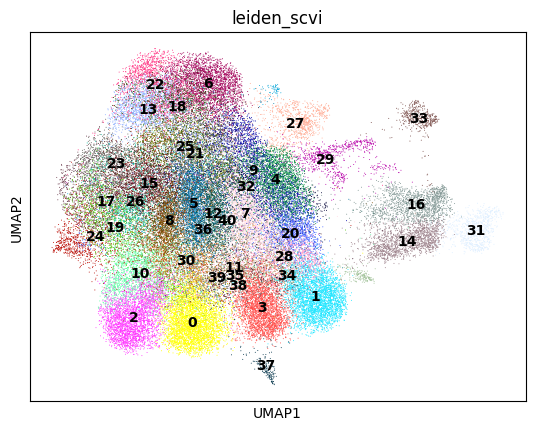

CPU times: user 2min 38s, sys: 4.15 s, total: 2min 42s
Wall time: 2min 22s


In [13]:
%%time
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [14]:
%%time
adata.write(cwd+'/outs/240105_schimdt_scvi.h5ad')
scvi_model.save(cwd+'/outs/240105_schimdt_scvi_model/', overwrite=True)

CPU times: user 382 ms, sys: 8.32 s, total: 8.7 s
Wall time: 32.6 s
